# Create reviewed detection history of individuals:

In 6_review_phase1.ipynb, we reviewed clusters on a per-point basis. We removed clusters without a majority class, marked clusters that should be merged

Now, we create a dection history for individuals by confirming the presence of each individual on a per point, per day (12 consecutive days Mat 15-26), per year basis. 

Note that points are treated as independent: we do not consider the possibility of birds moving between points. 

Display a set of the reviewed and included clips from the cluster.

In [3]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import pyplot as plt
def figsize(w,h):
    plt.rcParams['figure.figsize']=[w,h]
figsize(15,5) #for big visuals
%config InlineBackend.figure_format = 'retina'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


def identity(x):
    return x

from opensoundscape import Audio, Spectrogram

# palette with many colors, starts w light grey
palette_w_grey = [(0.9, 0.9, 0.9)] + sns.color_palette("deep") + sns.color_palette("Dark2")
palette = sns.color_palette("deep") + sns.color_palette("Dark2")

In [ ]:
pam_dataset_path = "../../../pam_dataset_v4/"


annotated_cluster_samples = pd.read_csv(
    f"{pam_dataset_path}/per_point_clusters_reviewed.csv",
    parse_dates=["date", "time"],
)
annotated_cluster_samples["features3d"] = annotated_cluster_samples["features3d"].apply(
    eval
)

all_cluster_samples = pd.read_csv(
    f"{pam_dataset_path}/all_clips_with_cleaned_clusters.csv",
    parse_dates=["date", "time", "datetime"],
)
all_cluster_samples["features3d"] = all_cluster_samples["features3d"].apply(eval)
all_cluster_samples["date"] = all_cluster_samples.date.apply(lambda x: x.date())
all_cluster_samples["year"] = all_cluster_samples.date.apply(lambda x: x.year)
annotated_cluster_samples["year"] = annotated_cluster_samples["date"].apply(
    lambda x: x.year
)

all_cluster_samples["file"] = all_cluster_samples["clip_name"].apply(
    lambda x: f"{pam_dataset_path}/audio/{x}"
)

/tmp/ipykernel_1958300/3037725436.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  annotated_cluster_samples = pd.read_csv(
/tmp/ipykernel_1958300/3037725436.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_cluster_samples = pd.read_csv(


In [51]:
# from pathlib import Path
# all_cluster_samples.file.apply(lambda x: Path(x).exists()).all()

for each culster, for each day, for each year:

find (1?) clip(s) with most similar feature embedding to any of the reviewed and included clips

In [52]:
# figsize(1.5, 1.5)
# cluster_centroids = {}
# for cluster, examples in annotated_cluster_samples.groupby("cluster_reviewed"):
#     v = np.stack(examples["features3d"].values)
#     cluster_centroids[cluster] = v.mean(0)
#     # plt.scatter(v[:,0],v[:,1])
#     # plt.scatter(cluster_centroids[cluster][0],cluster_centroids[cluster][1])
#     # plt.show()

In [53]:
all_cluster_samples = all_cluster_samples.sort_values(by="cluster_reviewed")

In [8]:
dfs = []
for year in [2021, 2022, 2023, 2024]:
    cluster_date_df = pd.DataFrame(
        index=all_cluster_samples["cluster_reviewed"].unique(),
        columns=[
            "5/15",
            "5/16",
            "5/17",
            "5/8",
            "5/19",
            "5/20",
            "5/21",
            "5/22",
            "5/23",
            "5/24",
            "5/25",
            "5/26",
        ],
    )
    cluster_date_df["year"] = year
    cluster_date_df.index.name = "cluster_reviewed"
    dfs.append(cluster_date_df.reset_index(drop=False))
df = pd.concat(dfs).sort_values(by=["cluster_reviewed", "year"])
df = df[list(df.columns[-1:]) + list(df.columns[:-1])]
df.to_csv(f"{pam_dataset_path}/detection_history_blank.csv")
# cluster_year_df.to_csv(f"{pam_dataset_path}/detection_history.csv")

create annotation task: each individual, most similar 1 clip to any clip reviewed and included in cluster review for each of 12 days on 4 years


## annotation: 

mark 1 if present


mark 0 if not present

In [9]:
import datetime

dates = []
for first_date in [
    datetime.date(2021, 5, 15),
    datetime.date(2022, 5, 15),
    datetime.date(2023, 5, 15),
    datetime.date(2024, 5, 15),
]:
    dates.extend([first_date + datetime.timedelta(days=d) for d in range(12)])

In [10]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


def closest_index(A, B):
    similarities = np.array([[cosine_similarity(a, b) for b in B] for a in A])
    return similarities.max(axis=1).argmax()

In [74]:
skip_until = "RK693_0"
skip = True

RK693_0


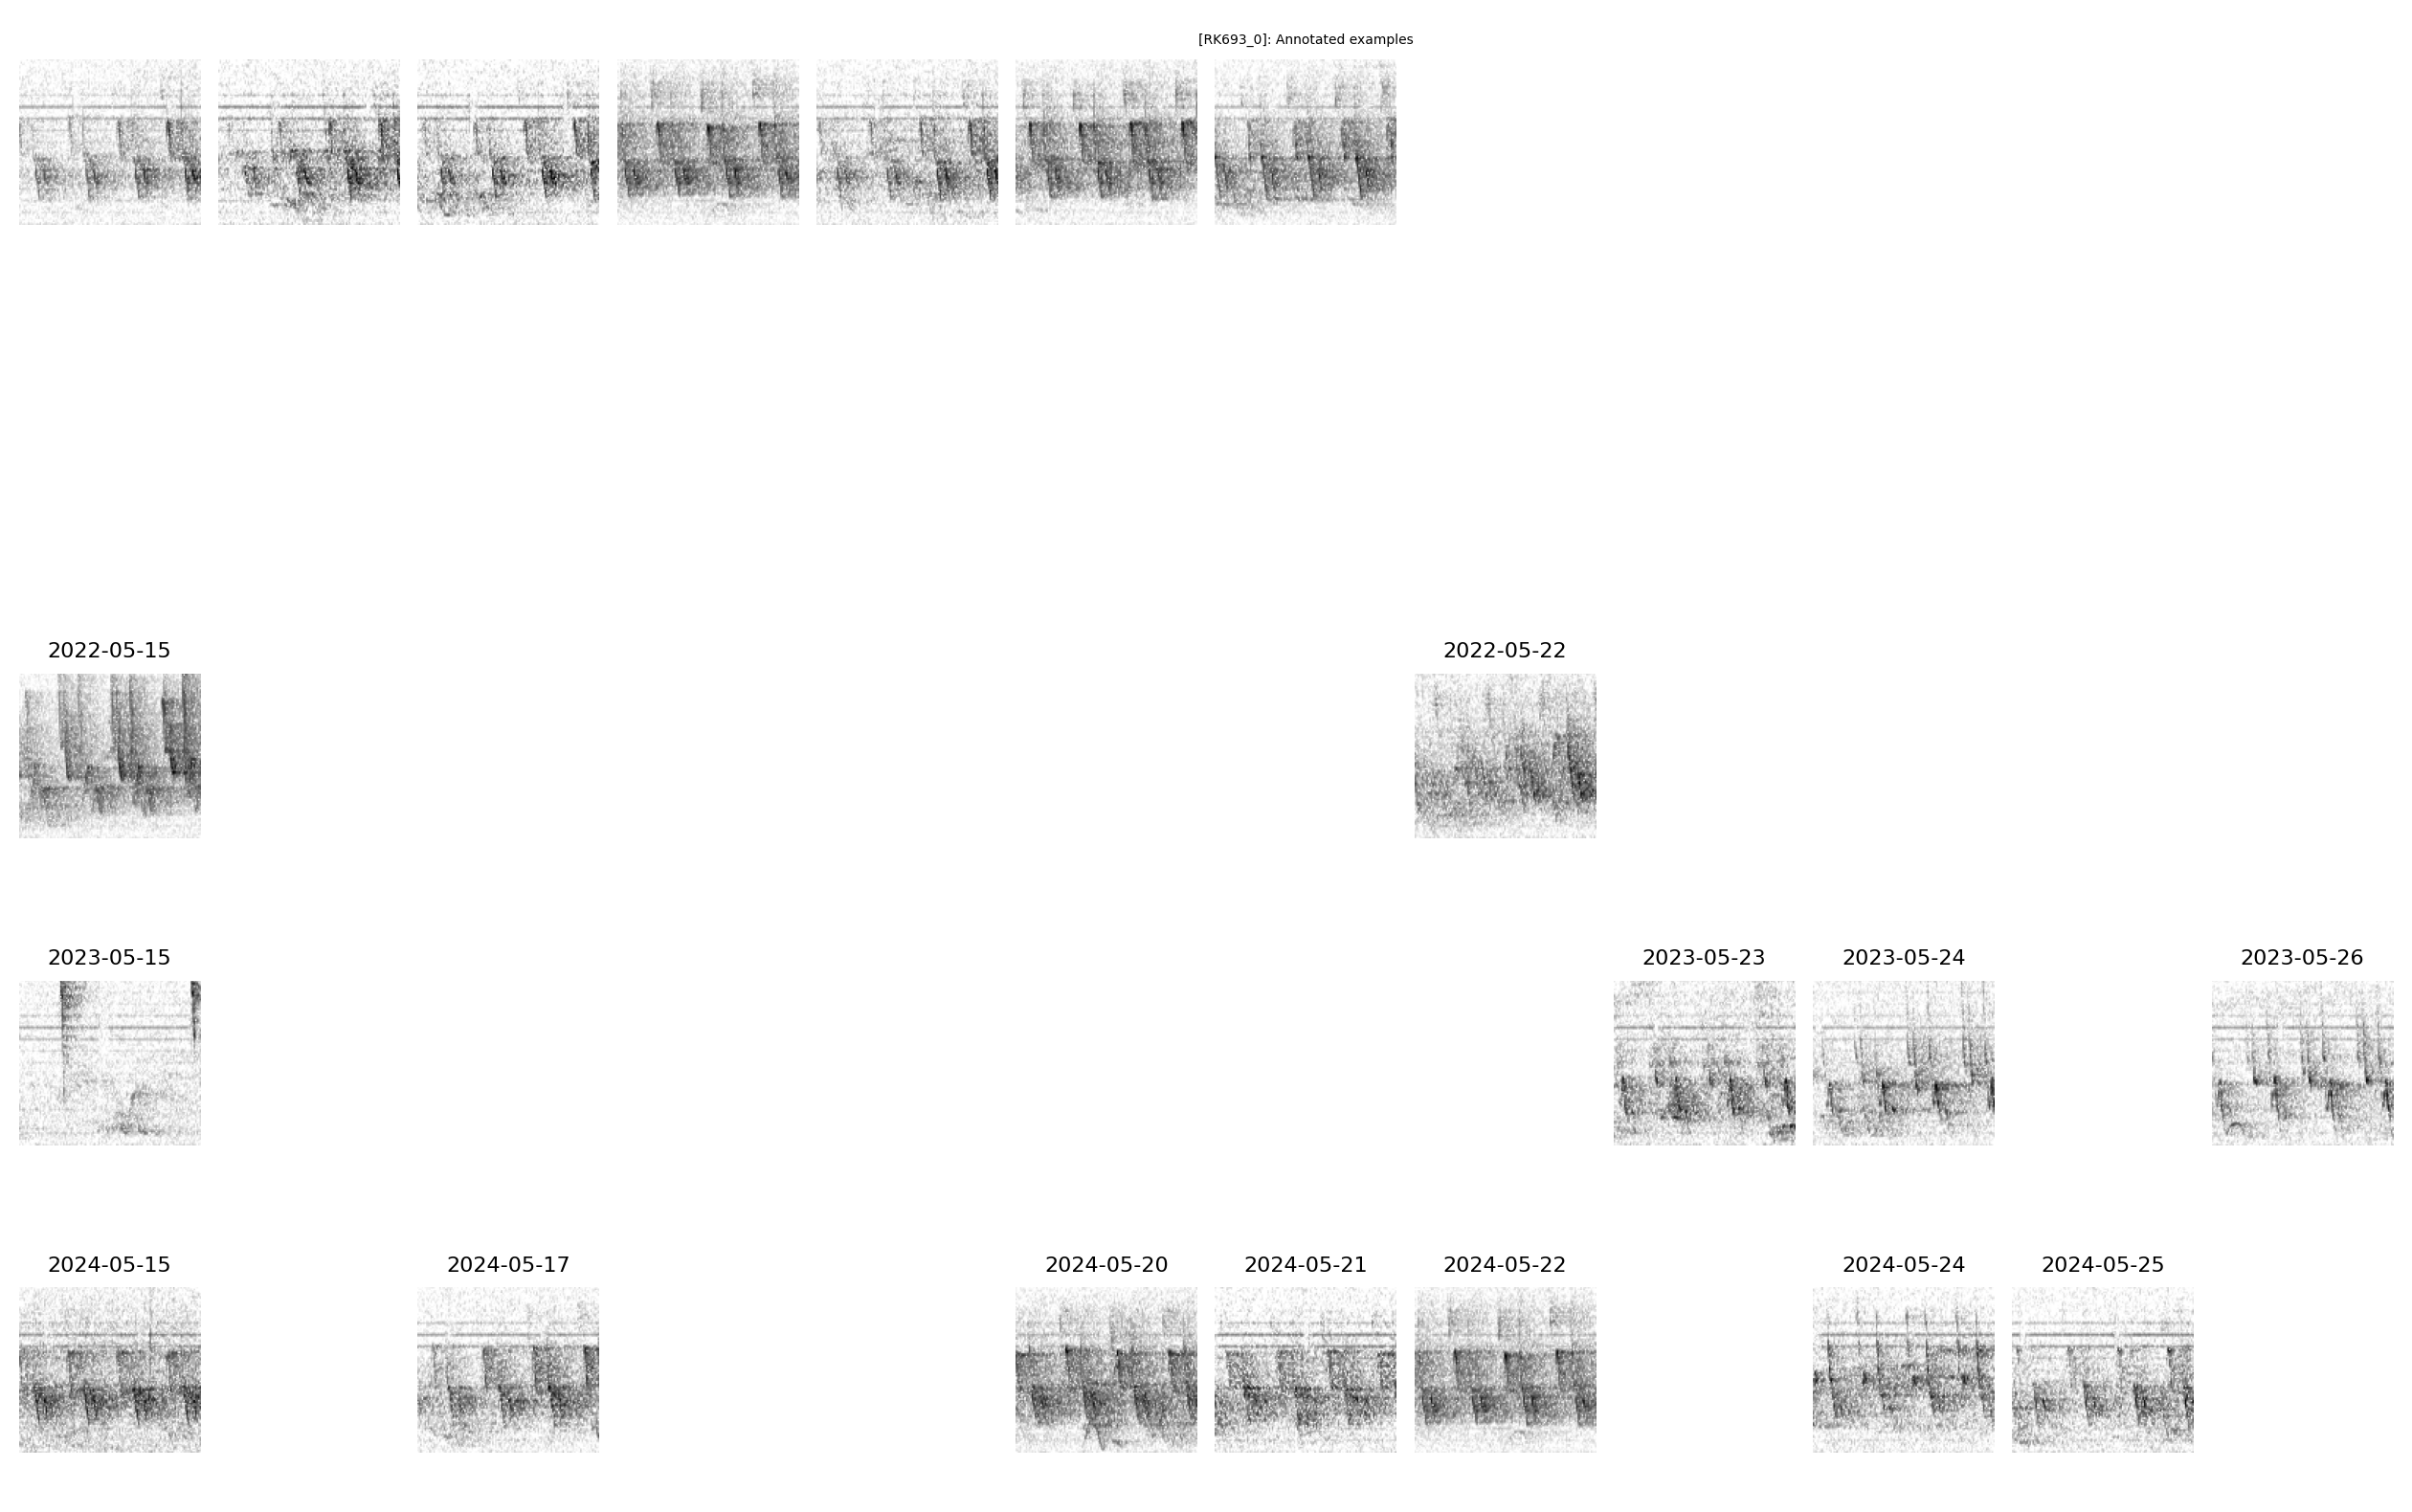

In [75]:
year_idx = {2021: 0, 2022: 1, 2023: 2, 2024: 3}
spec_range = (-85, 0)

for cluster, clips in all_cluster_samples.groupby("cluster_reviewed"):
    if cluster == skip_until:
        skip = False
    if skip:
        continue

    print(cluster)
    nyears = len(clips["year"].unique())
    nrows = 5  # nyears + 1
    # n_per_cluster = 1

    fig, axes = plt.subplots(nrows, 12, figsize=(16, 2 * nrows))

    annotated = annotated_cluster_samples[
        annotated_cluster_samples["cluster_reviewed"] == cluster
    ]
    annotated = annotated.sample(10) if len(annotated) > 10 else annotated
    for i, row in annotated.reset_index(drop=False).iterrows():

        ax = axes[0, i]
        # from 3s clip, grab 1s in the middle
        a = Audio.from_file(row.file, offset=1, duration=1)
        ax.imshow(
            Spectrogram.from_audio(a)
            .bandpass(2000, 9000)
            .to_image(range=spec_range, return_type="np")[0],
            cmap="Greys",
        )
    ax.set_title(f"[{cluster}]: Annotated examples", fontsize=5)

    annotated_feat = np.vstack(annotated["features3d"])

    for ii, date in enumerate(list(dates)):
        date_clips = clips[clips.date == date]
        if len(date_clips) < 1:
            continue  # no matches

        # find clip nearest to any annotated clip
        date_feat = np.vstack(date_clips["features3d"])

        row = date_clips.iloc[closest_index(date_feat, annotated_feat)]

        ax = axes[year_idx[date.year] + 1, ii % 12]
        # from 3s clip, grab 1s in the middle
        a = Audio.from_file(row.file, offset=1, duration=1)
        ax.imshow(
            Spectrogram.from_audio(a)
            .bandpass(2000, 9000)
            .to_image(range=spec_range, return_type="np")[0],
            cmap="Greys",
        )
        ax.set_title(f"{row['date']}", fontsize=8)

    # remove all axes
    for row in axes:
        for ax in row:
            ax.axis("off")  # Hide axes
            ax.set_xticks([])  # Remove x ticks
            ax.set_yticks([])  # Remove y ticks

    # Adjust spacing between images
    plt.subplots_adjust(wspace=0.1, hspace=0.25)

    plt.show()
    cmd = input("x to exit, or ID")
    if cmd == "x":
        skip_until = cluster
        skip = True
        break
    # elif "RK" in cmd:
    #     skip_until = cmd
    #     skip = True
    #     break

    clear_output()